# Collect archived Airnow Data

Use the API to download Airnow data from select stations

## Load python packages

In [1]:
import numpy as np
import pandas as pd
from pandas.tseries.offsets import DateOffset
import matplotlib.pyplot as plt
import datetime
from pathlib import Path # System agnostic paths

import requests # for url requests
import json # for json reading/writing
import time # for epoch timestamp
import csv # for writing csv files

## Setup website query keys

In [120]:
url = 'https://aqs.epa.gov/data/api/sampleData/bySite?'
    
keys = {
        'email': 'rsh@ucar.edu', #for access to the api
        'key': 'saffronkit74', #for access to the api
        'param': '88500', #88500 ("PM2.5 Total Atmospheric" for CU Athens) or 88101 ("PM2.5 Local Conditions" for Longmont)
        'bdate': '20200801', #begin date (modify as needed, YYYYMMDD)
        'edate': '20201105', #end date (modify as needed, YYYYMMDD)
        'state': '08', #Colorado
        'county': '013', #Boulder County
        'site': '1001', #1001 (for CU Athens) or 0003 (for Longmont)
        }


query_AirNow = requests.get(url, keys)

## Use json reader to convert and pandas to format into array

In [121]:
response_list = query_AirNow.json()
# Uncomment below to see the result of the website query
# response_list

In [122]:
data_extract = pd.DataFrame(response_list.get('Data'))
data_extract

,state_code,county_code,site_number,parameter_code,poc,latitude,longitude,datum,parameter,date_local,...,detection_limit,uncertainty,qualifier,method_type,method,method_code,state,county,date_of_last_change,cbsa_code
0,08,013,1001,88500,3,40.012969,-105.267212,WGS84,PM2.5 Total Atmospheric,2020-11-05,...,0.06,None,None,Non-FRM,PM2.5 VSCC - FDMS-Gravimetric,761,Colorado,Boulder,2021-02-18,14500
1,08,013,1001,88500,3,40.012969,-105.267212,WGS84,PM2.5 Total Atmospheric,2020-11-05,...,0.06,None,None,Non-FRM,PM2.5 VSCC - FDMS-Gravimetric,761,Colorado,Boulder,2021-02-18,14500
2,08,013,1001,88500,3,40.012969,-105.267212,WGS84,PM2.5 Total Atmospheric,2020-11-05,...,0.06,None,None,Non-FRM,PM2.5 VSCC - FDMS-Gravimetric,761,Colorado,Boulder,2021-02-18,14500
3,08,013,1001,88500,3,40.012969,-105.267212,WGS84,PM2.5 Total Atmospheric,2020-11-05,...,0.06,None,None,Non-FRM,PM2.5 VSCC - FDMS-Gravimetric,761,Colorado,Boulder,2021-02-18,14500
4,08,013,1001,88500,3,40.012969,-105.267212,WGS84,PM2.5 Total Atmospheric,2020-11-05,...,0.06,None,None,Non-FRM,PM2.5 VSCC - FDMS-Gravimetric,761,Colorado,Boulder,2021-02-18,14500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2323,08,013,1001,88500,3,40.012969,-105.267212,WGS84,PM2.5 Total Atmospheric,2020-08-01,...,0.06,None,None,Non-FRM,PM2.5 VSCC - FDMS-Gravimetric,761,Colorado,Boulder,2020-11-20,14500
2324,08,013,1001,88500,3,40.012969,-105.267212,WGS84,PM2.5 Total Atmospheric,2020-08-01,...,0.06,None,AN - Machine Malfunction.,Non-FRM,PM2.5 VSCC - FDMS-Gravimetric,761,Colorado,Boulder,2020-11-20,14500
2325,08,013,1001,88500,3,40.012969,-105.267212,WGS84,PM2.5 Total Atmospheric,2020-08-01,...,0.06,None,None,Non-FRM,PM2.5 VSCC - FDMS-Gravimetric,761,Colorado,Boulder,2020-11-20,14500
2326,08,013,1001,88500,3,40.012969,-105.267212,WGS84,PM2.5 Total Atmospheric,2020-08-01,...,0.06,None,AN - Machine Malfunction.,Non-FRM,PM2.5 VSCC - FDMS-Gravimetric,761,Colorado,Boulder,2020-11-20,14500


## Note the API is in reverse order: edate is at the top of the record, bdate is at the bottom of the record so need to reorder:

In [123]:
data = data_extract[::-1]

## Query the column headers to figure out what to extract

In [124]:
data.columns

Index(['state_code', 'county_code', 'site_number', 'parameter_code', 'poc',
       'latitude', 'longitude', 'datum', 'parameter', 'date_local',
       'time_local', 'date_gmt', 'time_gmt', 'sample_measurement',
       'units_of_measure', 'units_of_measure_code', 'sample_duration',
       'sample_duration_code', 'sample_frequency', 'detection_limit',
       'uncertainty', 'qualifier', 'method_type', 'method', 'method_code',
       'state', 'county', 'date_of_last_change', 'cbsa_code'],
      dtype='object')

## Extract data separately to make sure formatting is correct.

In [130]:
# Use pandas to convert to datetime format
extracted_date = pd.to_datetime(data['date_gmt'] + ' ' +data['time_gmt'])
# PM2.5 should be a float
extracted_pm25 = data['sample_measurement']

## Plot

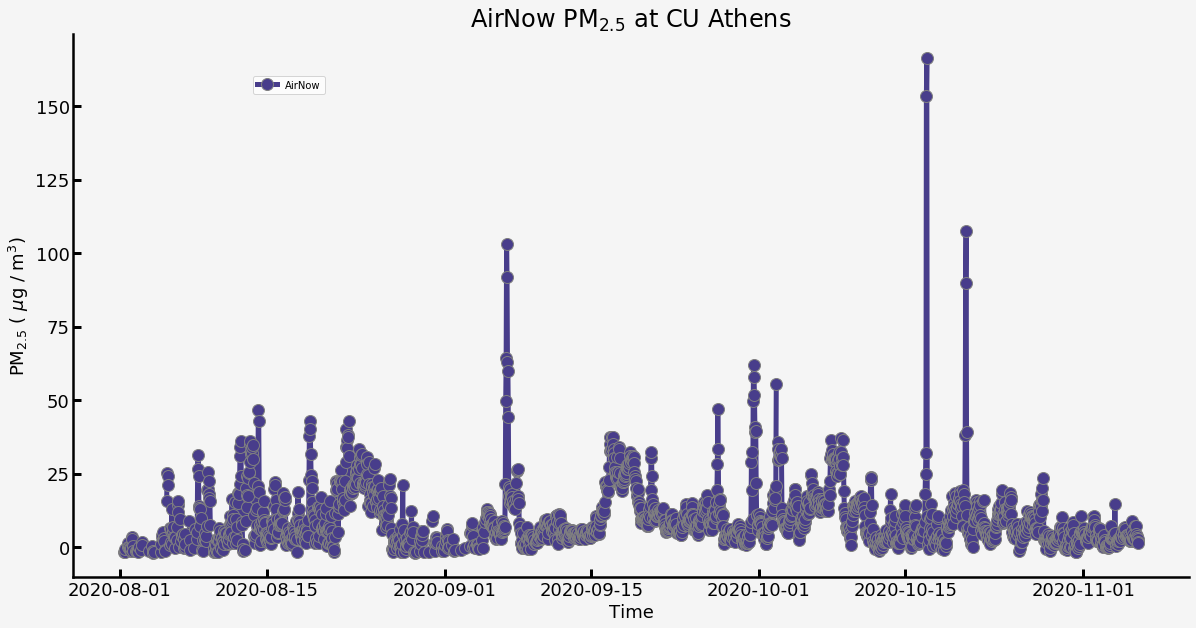

In [128]:
plt.figure(figsize=(20,10),facecolor='whitesmoke')
ax = plt.axes(facecolor='whitesmoke')

plt.plot(extracted_date, extracted_pm25, '-o', label='AirNow',
         color='darkslateblue',
         markersize=12, linewidth=5,
         markerfacecolor='darkslateblue',
         markeredgecolor='grey',
         markeredgewidth=1)

#resources: named colors - https://matplotlib.org/examples/color/named_colors.html
#           default markers and lines list - https://matplotlib.org/2.1.2/api/_as_gen/matplotlib.pyplot.plot.html


# axes format
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
#ax.set_ylim(90, 200)
#plt.yticks(np.arange(0, 50, step=20), fontsize=18)

# tickmarks direction
ax.tick_params(direction='in', length=8, width=3)

# adjust border
ax.spines["left"].set_linewidth(2.5)
ax.spines["bottom"].set_linewidth(2.5)
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)

# titles
plt.title('AirNow PM$_{2.5}$ at CU Athens',fontsize=24)
plt.xlabel('Time',fontsize=18)
plt.ylabel('PM$_{2.5}$ ( $\mu$g / m$^3$)',fontsize=18)

# legend
plt.legend(bbox_to_anchor=(0.23, 0.88),loc='lower right')

# write to show the whole plot
plt.show()
#plt.savefig('AirNow_timeseries_CUAthens.png')